In [29]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
import pathlib

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
DATA_PATH = pathlib.Path('dataset') / "chest_xray"
TRAIN_PATH = DATA_PATH / "train"
TEST_PATH = DATA_PATH / 'test'
VAL_PATH = DATA_PATH / 'val'

In [17]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(TRAIN_PATH, transform=transform)
val_dataset = datasets.ImageFolder(VAL_PATH, transform=transform)
test_dataset = datasets.ImageFolder(TEST_PATH, transform=transform)

train_dataset, val_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 5216
     Root location: dataset\chest_xray\train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 16
     Root location: dataset\chest_xray\val
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 624
     Root location: dataset\chest_xray\test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [18]:
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [19]:
classes = {
    0: "Normal",
    1: "Pneumonia"
          }

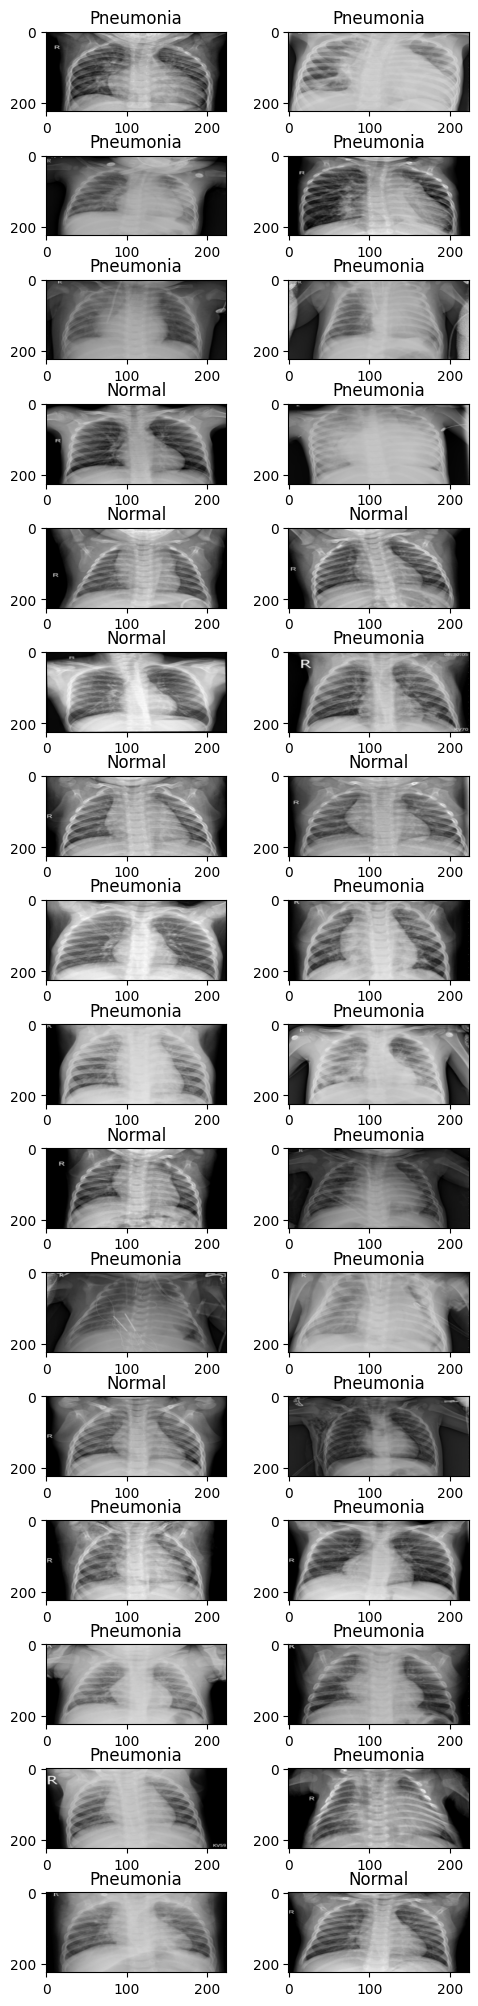

In [20]:
for img, label in train_dataloader:
    fig, ax = plt.subplots(nrows = int(BATCH_SIZE / 2), ncols = 2, figsize=(5, 20))
    fig.tight_layout()
    for i in range(BATCH_SIZE):
        ax[int(i/2), i%2].imshow(img[i].permute(1, 2, 0), aspect='auto')
        ax[int(i/2), i%2].set_title(classes[label[i].item()])
    break

In [52]:
class BayesianNN(torch.nn.Module):
    def __init__(self):
        super(BayesianNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = torch.nn.Linear(64*56*56, 256)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(256, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = self.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [57]:
bnn = BayesianNN().to(device)
criterion = torch.nn.BCELoss()

# Set up parameters for SGLD (Stochastic Gradient Langevin Dynamics)
learning_rate = 1e-3  # Learning rate
num_epochs = 5  # Number of epochs
burn_in = 100  # Burn-in period to discard early samples
num_samples = 50  # Number of posterior samples to collect

In [58]:
def sgld_update(param, param_grad, lr, noise_std):
    noise = torch.randn(param.size(), device=param.device) * noise_std
    return param - 0.5 * lr * param_grad + noise

# Training function using SGLD
def train_sgld(bnn, train_loader, criterion, num_epochs, lr, burn_in, num_samples):
    bnn.train()  # Set model to training mode

    # Store samples of the network's parameters
    samples = []

    # Total training steps
    total_steps = len(train_loader)
    
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device).float()

            # Zero the gradients
            bnn.zero_grad()

            # Forward pass
            outputs = bnn(images)
            loss = criterion(outputs.view(-1), labels.view(-1))

            # Backward pass (compute gradients)
            loss.backward()

            # SGLD update with noise
            with torch.no_grad():
                for param in bnn.parameters():
                    param.grad.data.add_(torch.randn_like(param) * np.sqrt(2 / lr))  # Add Langevin noise
                    param.data = sgld_update(param.data, param.grad.data, lr, noise_std=np.sqrt(2 * lr))

            # After burn-in, collect samples
            if epoch >= burn_in and (i % (total_steps // num_samples) == 0):
                # Collect a sample of the model's parameters
                param_sample = {name: param.clone().cpu() for name, param in bnn.named_parameters()}
                samples.append(param_sample)
            
            if (i + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')
    
    return samples

# Train the Bayesian Neural Network using SGLD
posterior_samples = train_sgld(bnn, train_dataloader, criterion, num_epochs, learning_rate, burn_in, num_samples)

Epoch [1/5], Step [10/163], Loss: 25.0000
Epoch [1/5], Step [20/163], Loss: 31.2500
Epoch [1/5], Step [30/163], Loss: 31.2500
Epoch [1/5], Step [40/163], Loss: 21.8750
Epoch [1/5], Step [50/163], Loss: 37.5000
Epoch [1/5], Step [60/163], Loss: 15.6250
Epoch [1/5], Step [70/163], Loss: 34.3750
Epoch [1/5], Step [80/163], Loss: 25.0000
Epoch [1/5], Step [90/163], Loss: 34.3750
Epoch [1/5], Step [100/163], Loss: 31.2500
Epoch [1/5], Step [110/163], Loss: 21.8750
Epoch [1/5], Step [120/163], Loss: 31.2500
Epoch [1/5], Step [130/163], Loss: 18.7500
Epoch [1/5], Step [140/163], Loss: 46.8750
Epoch [1/5], Step [150/163], Loss: 15.6250
Epoch [1/5], Step [160/163], Loss: 15.6250
Epoch [2/5], Step [10/163], Loss: 18.7500
Epoch [2/5], Step [20/163], Loss: 46.8750


KeyboardInterrupt: 

In [ ]:
def predict_with_uncertainty(bnn, posterior_samples, data_loader):
    bnn.eval()  # Set model to evaluation mode

    # Store all predictions from different posterior samples
    all_preds = []

    with torch.no_grad():
        for i, (images, _) in enumerate(data_loader):
            images = images.to(device)

            preds = []
            for sample in posterior_samples:
                # Load a sample of the parameters into the model
                for name, param in bnn.named_parameters():
                    param.copy_(sample[name])

                # Perform forward pass with the sampled parameters
                outputs = bnn(images)
                preds.append(outputs.cpu().numpy())

            # Aggregate predictions from all posterior samples
            preds = np.stack(preds, axis=0)
            all_preds.append(preds)

    return all_preds

# Predict with uncertainty on the test set
predictions = predict_with_uncertainty(bnn, posterior_samples, test_dataloader)